In [1]:
import os
import glob
import torch
import cv2
import random
from tqdm import tqdm
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install segmentation-models-pytorch
import ssl
ssl._create_default_https_context = ssl._create_unverified_context



  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=2a0752a0d9301942f4a638f97ae87fb8ce6fa0f093817ec7d3d664f13b2611f4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=181e99d7e359ea7faa2dfd4ec3bc765086ff3e07aec6bea297bf55bd8aacd161
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
image_paths = glob.glob('/kaggle/input/brain-tumor-segmentation/images/*')  # Use wildcard *
mask_paths = glob.glob('/kaggle/input/brain-tumor-segmentation/masks/*')

print(f'{len(mask_paths)} {len(image_paths)}')

3064 3064


In [4]:
def plot_from_img_path(n_examples, list_img_paths, list_mask_paths):
    
    fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
    i = 0
    for ax in axs:
        image, mask = list_img_paths[i], list_mask_paths[i]
        image, mask = cv2.imread(image), cv2.imread(mask)
        ax[0].set_title("MRI images")
        ax[0].imshow(image)
        ax[1].set_title("Highlited abnormality")
        ax[1].imshow(image)
        ax[1].imshow(mask, alpha=0.2)
        ax[2].imshow(mask)
        ax[2].set_title("Abnormality mask")
        i += 1

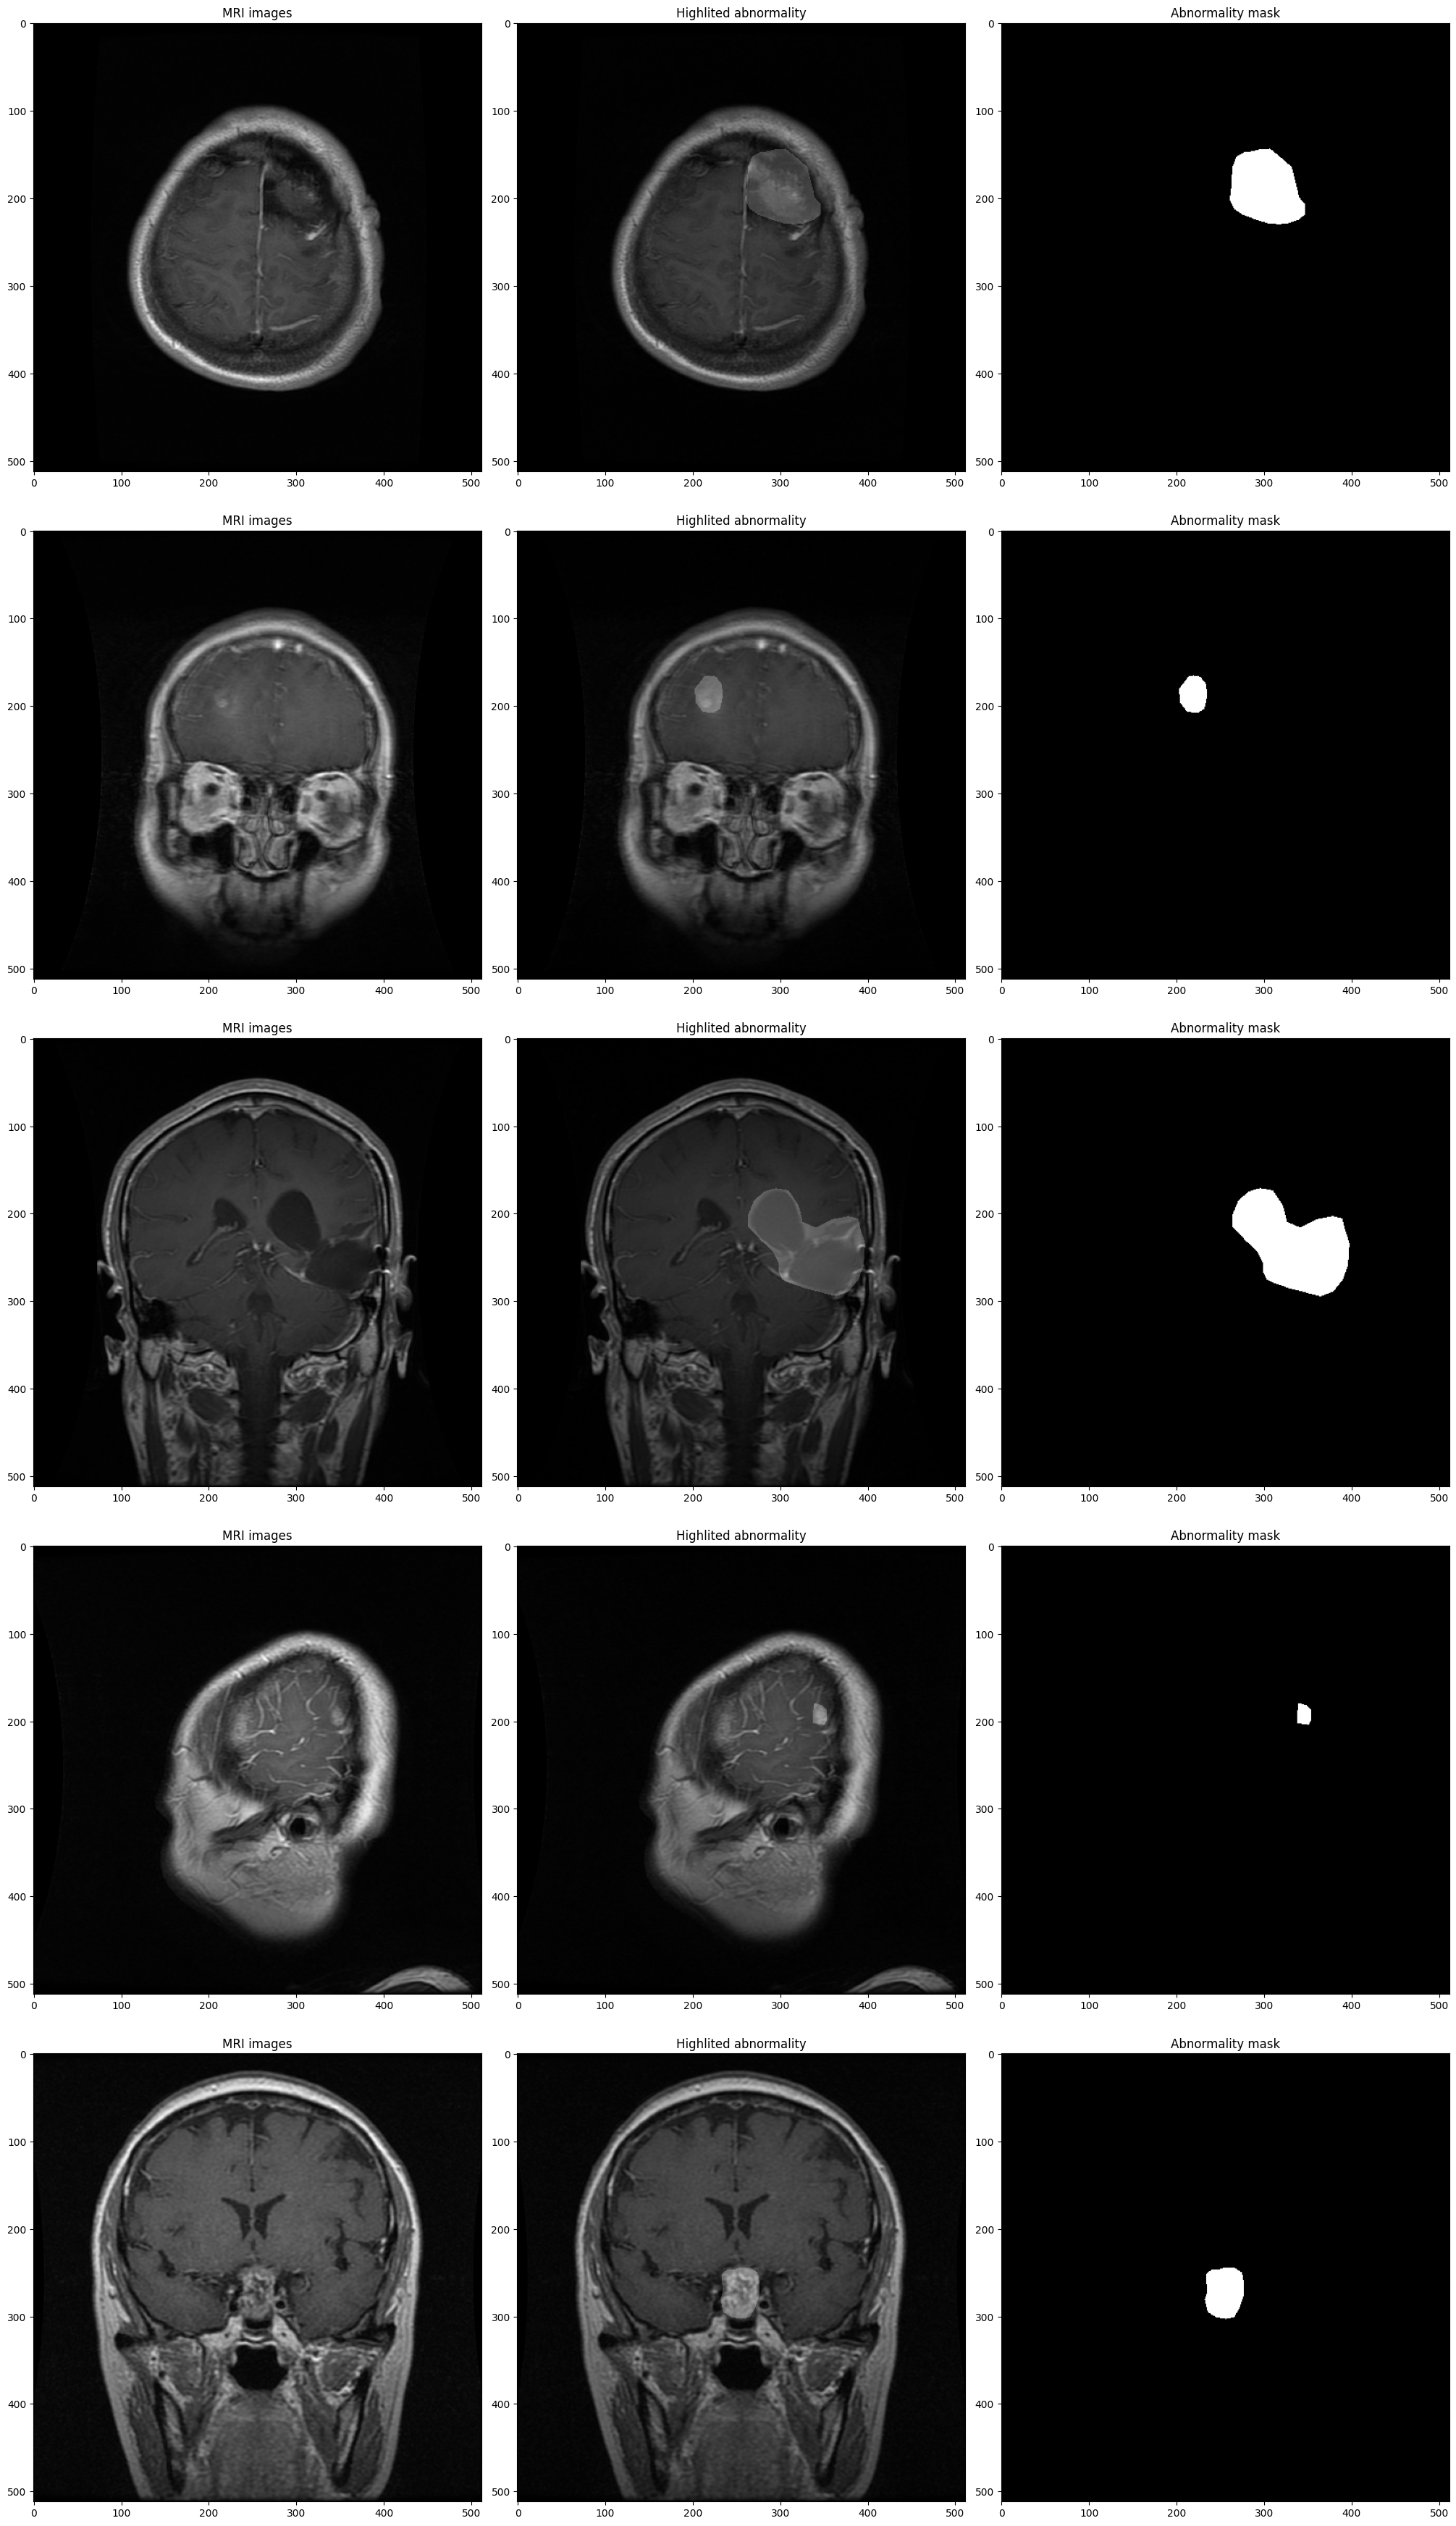

In [5]:
plot_from_img_path(n_examples=5, list_img_paths=image_paths[5:], list_mask_paths=mask_paths[5:])

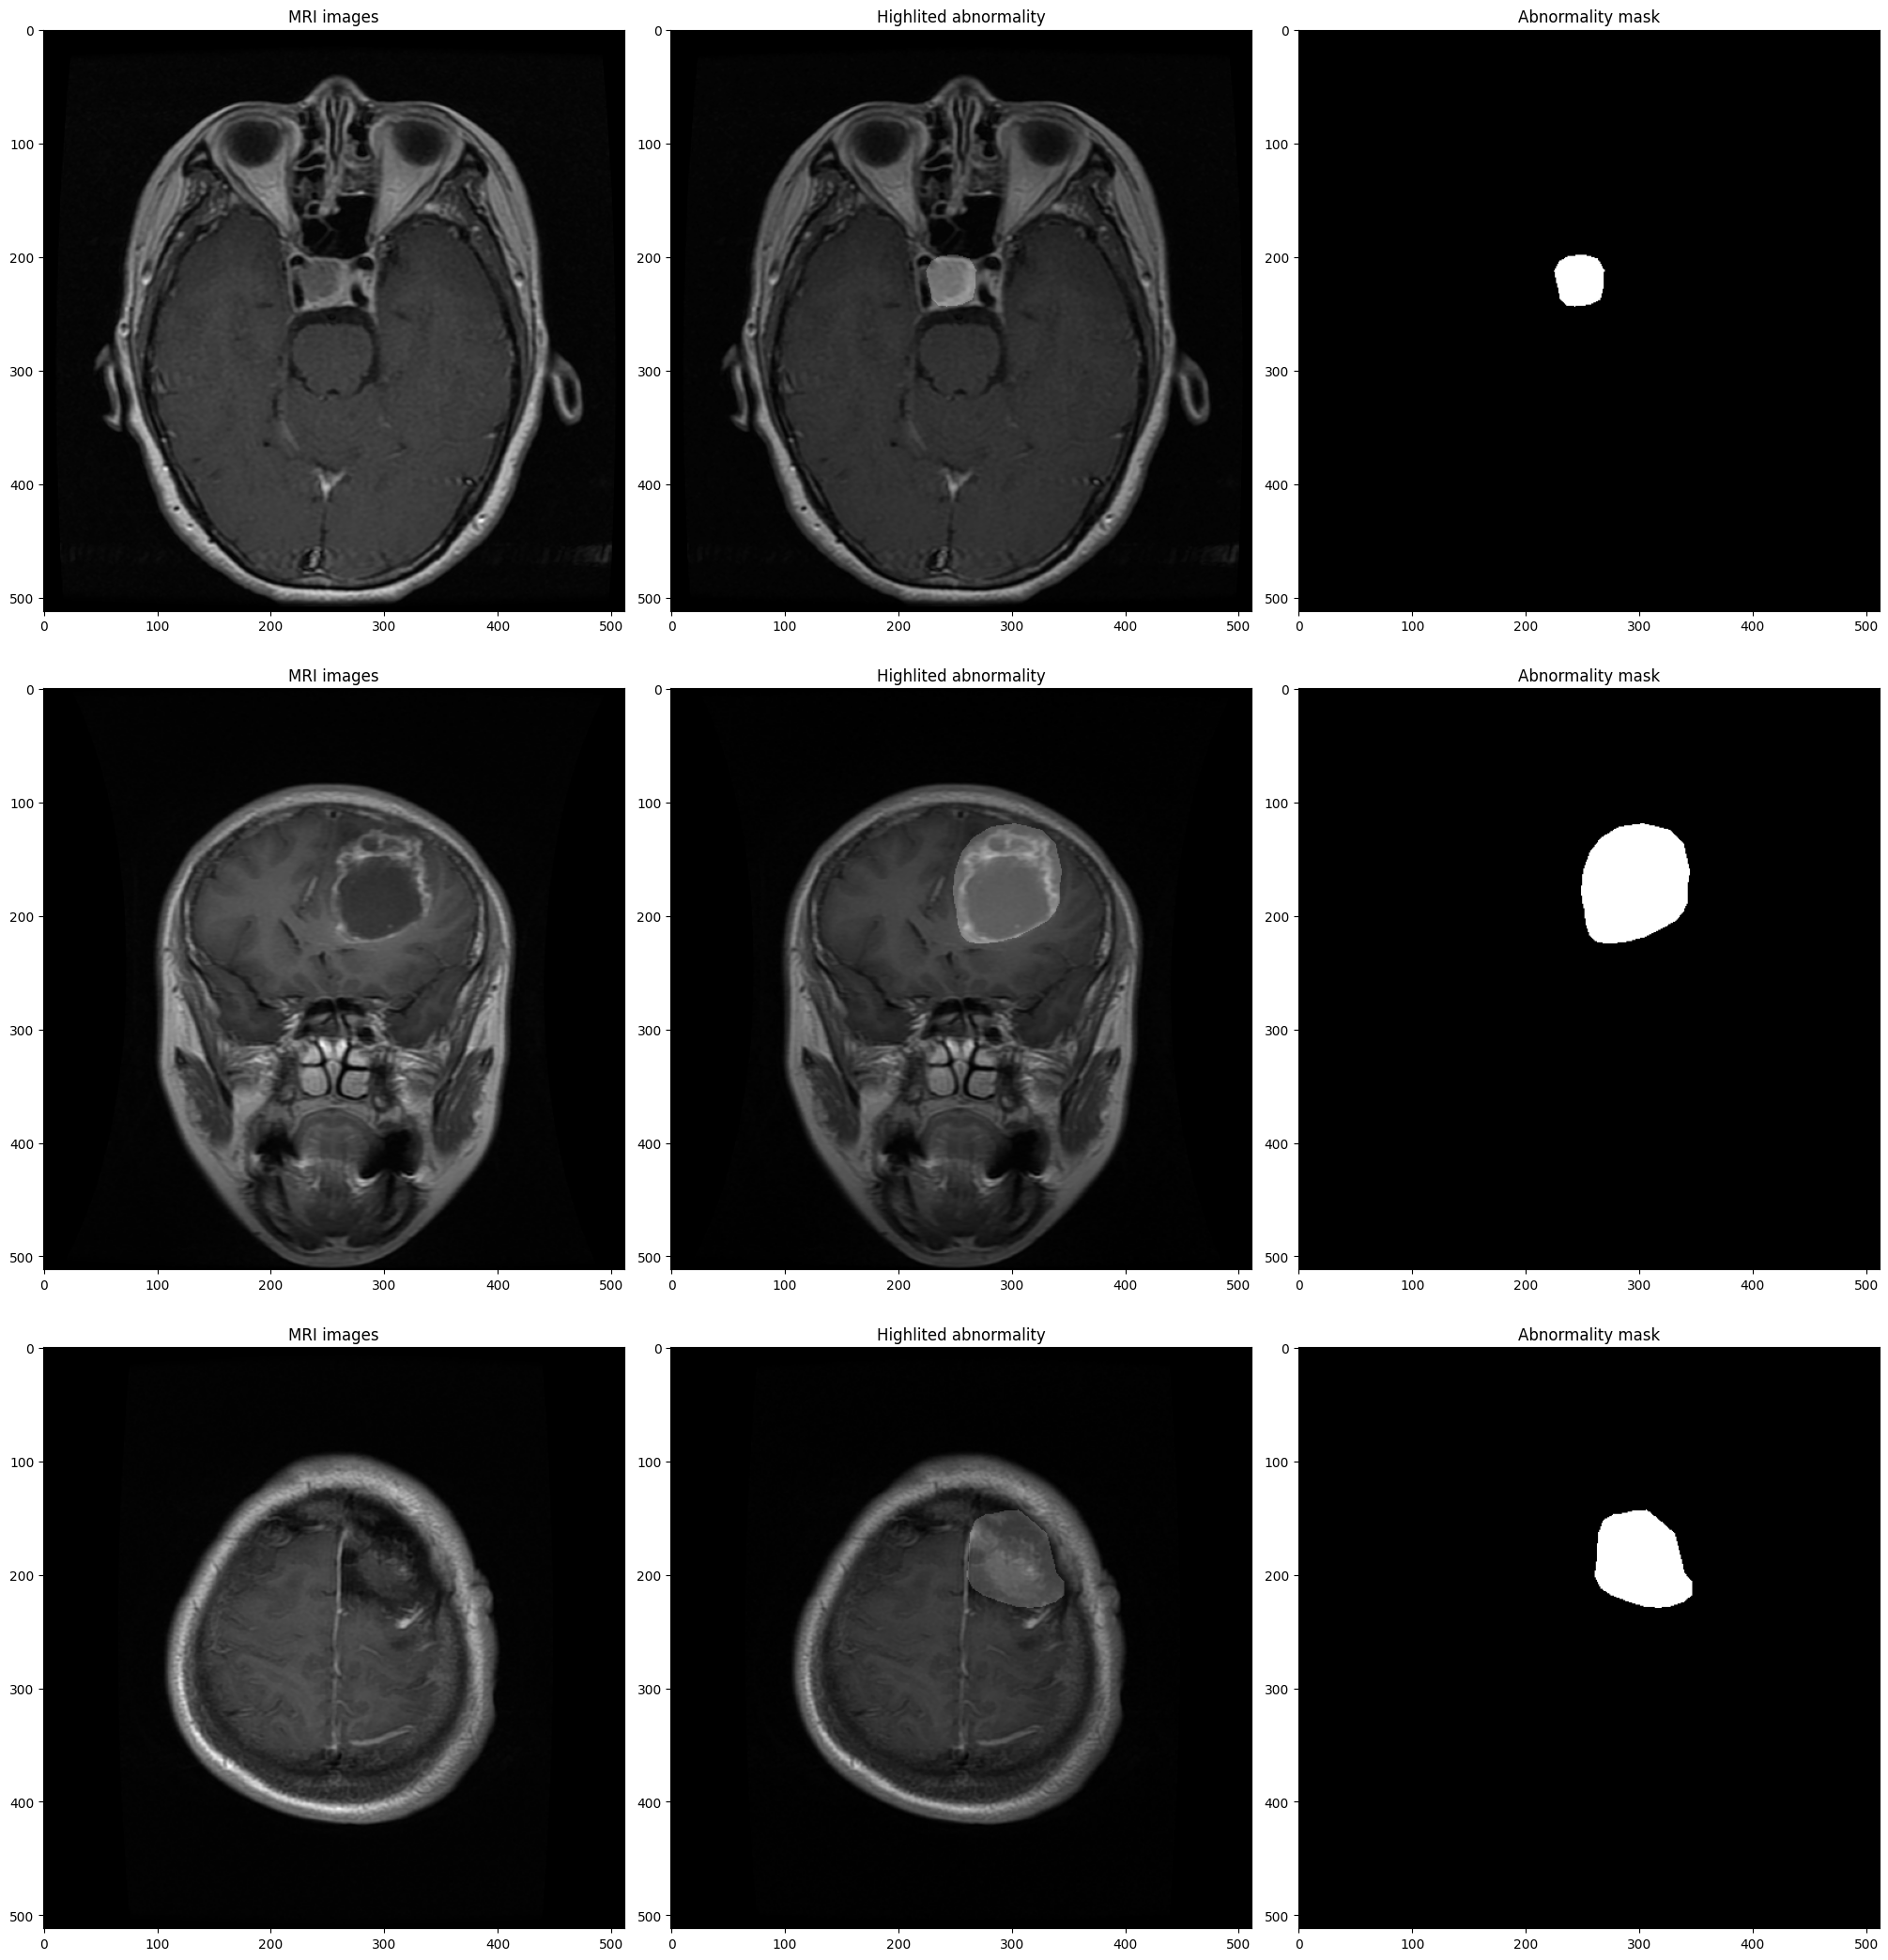

In [6]:
df = pd.DataFrame(data={'image': image_paths, 'mask': mask_paths})
df.head()
plot_from_img_path(n_examples=3, list_img_paths=df.iloc[[3,4,5],0].tolist(), list_mask_paths=df.iloc[[3,4,5],1].tolist())

In [7]:
from sklearn.model_selection import train_test_split

# Split into train (70%) and validation (30%)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# Print dataset sizes
print('Train:')
print(f"{df_train.describe().loc['count', ['image', 'mask']]}\n")

print('Validation:')
print(f"{df_val.describe().loc['count', ['image', 'mask']]}\n")


Train:
image    2451
mask     2451
Name: count, dtype: object

Validation:
image    613
mask     613
Name: count, dtype: object



In [8]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

# ----------------------------
# 1. Define Albumentations Transforms for Training
# ----------------------------
train_transform = A.Compose([
    # Ensure grayscale images have a channel dimension (if needed)
    A.Lambda(image=lambda x, **kwargs: x[..., None] if x.ndim == 2 else x),
  
    A.Rotate(limit=15, p=1.0),
    A.HorizontalFlip(p=0.5),
    #A.VerticalFlip(p=0.5),              # Vertical flip
   # A.RandomScale(scale_limit=0.2, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1.0),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.Resize(256, 256),    
    A.Normalize(mean=[0.0], std=[1.0], max_pixel_value=255.0),
    A.Lambda(mask=lambda x, **kwargs: x / 255.0),
    ToTensorV2()
])

# ----------------------------
# 2. Define Albumentations Transforms for Validation
# ----------------------------
# For validation, we typically only resize and convert to tensor (no augmentation)
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.0], std=[1.0], max_pixel_value=255.0),
    A.Lambda(mask=lambda x, **kwargs: x / 255.0),
    ToTensorV2()
])

# ----------------------------
# 3. Create a Custom Dataset Using Albumentations for Grayscale Images
# ----------------------------
class AlbumentationsDataset(Dataset):
    def __init__(self, df, transform=None, augment_times=1, train=True):
        """
        Args:
            df (pandas.DataFrame): DataFrame containing columns 'image' and 'mask' with file paths.
            transform: Albumentations transform to apply.
            augment_times (int): Number of times to augment each image during training.
            train (bool): Flag indicating if the dataset is for training.
        """
        self.image_paths = df['image'].tolist()
        self.mask_paths = df['mask'].tolist()
        self.transform = transform
        self.augment_times = augment_times if train else 1

    def __len__(self):
        return len(self.image_paths) * self.augment_times

    def __getitem__(self, idx):
        original_idx = idx % len(self.image_paths)
        # Read image and mask in grayscale
        img = cv2.imread(self.image_paths[original_idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[original_idx], cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        # Convert image to float32 if it's not already
        img = img.float()
        if mask.ndim == 2:
          mask = mask.unsqueeze(0)
        mask = mask.float()    
        return img, mask

# ----------------------------
# 4. Create the Datasets and DataLoaders
# ----------------------------
# Assume df_train and df_val are your training and validation DataFrames
augment_times = 2  # Number of augmentations per image for training

train_dataset = AlbumentationsDataset(
    df_train,
    transform=train_transform,
    augment_times=augment_times,
    train=True
)

val_dataset = AlbumentationsDataset(
    df_val,
    transform=val_transform,
    train=False  # No augmentation during validation
)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ----------------------------
# 5. Print Dataset Information
# ----------------------------
original_train_images = len(df_train)
augmented_train_images = len(train_dataset)  # After applying augmentation
print(f"Original Train Images: {original_train_images}")
print(f"Augmented Train Images: {augmented_train_images}")
print(f"Validation Dataset Size: {len(val_dataset)}")


Original Train Images: 2451
Augmented Train Images: 4902
Validation Dataset Size: 613


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-8-fbe6ee16ae9e>:11: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(image=lambda x, **kwargs: x[..., None] if x.ndim == 2 else x),
<ipython-input-8-fbe6ee16ae9e>:21: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(mask=lambda x, **kwargs: x / 255.0),
<ipython-input-8-fbe6ee16ae9e>:32: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(mask=lambda x, **kwargs: x / 255.0),


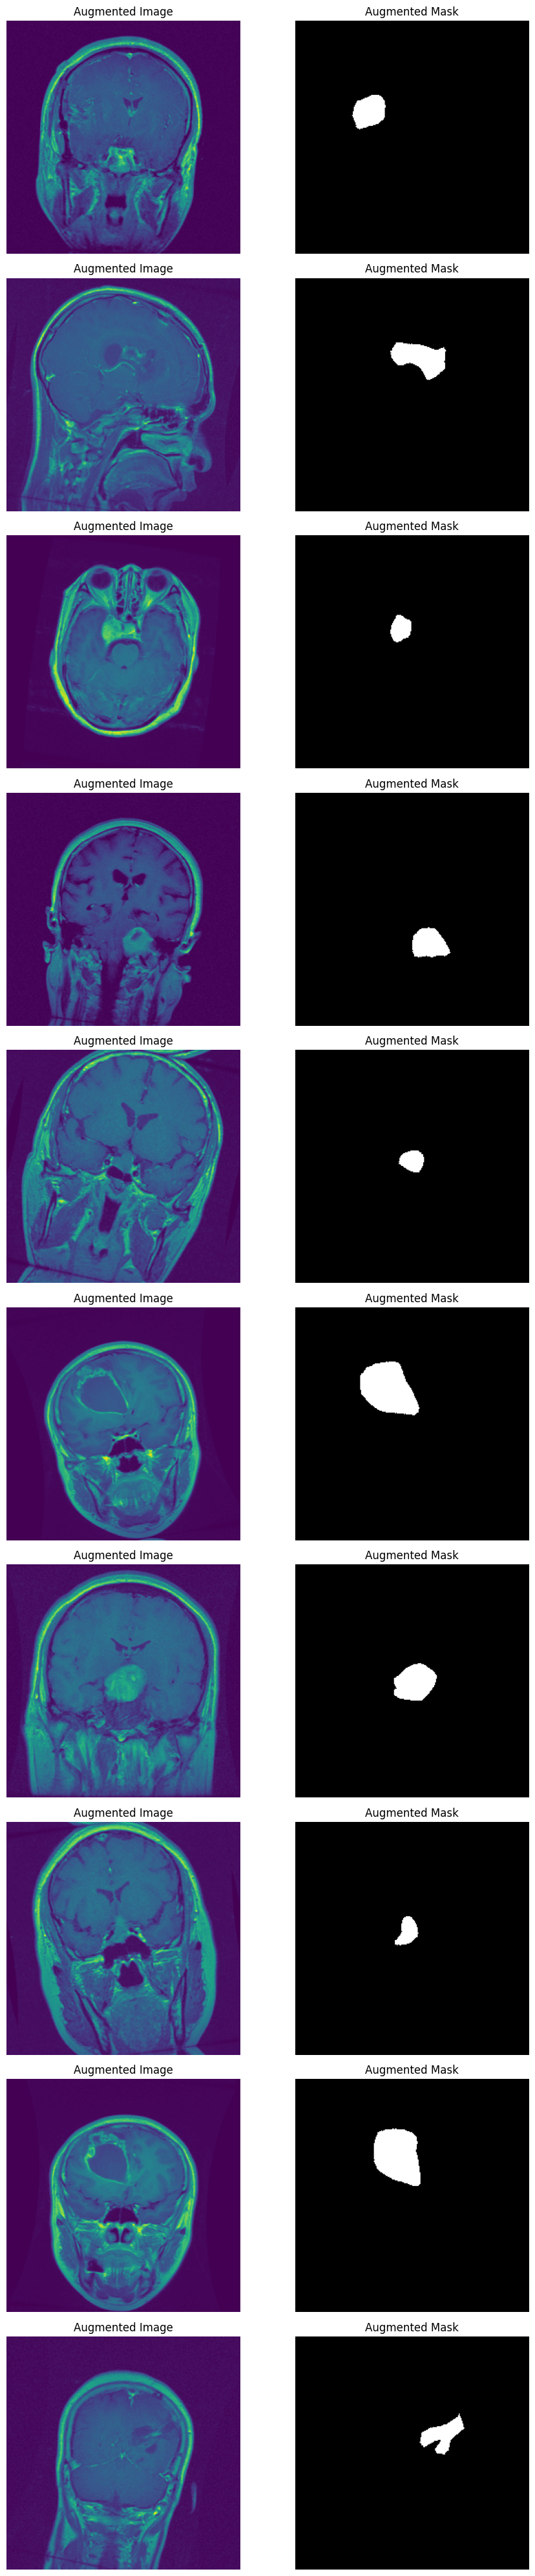

In [9]:
import matplotlib.pyplot as plt
import torch

def visualize_augmented_samples(dataset, num_samples=10):
    """
    Visualize the first num_samples of augmented image and mask pairs from an Albumentations-based dataset.
    Assumes:
      - Images are PyTorch tensors of shape (C, H, W) with values in [0, 1].
      - Masks are PyTorch tensors (either (1, H, W) or (H, W)).
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))
    
    for i in range(num_samples):
        # Get a sample from the dataset
        img, mask = dataset[i]
        
        # Convert image tensor (C, H, W) to numpy array (H, W, C)
        # Also move to CPU if necessary
        if isinstance(img, torch.Tensor):
            img_np = img.permute(1, 2, 0).cpu().numpy()
        else:
            img_np = img
        
        # Ensure mask is a 2D array: remove channel dim if it exists and move to CPU
        if isinstance(mask, torch.Tensor):
            mask_np = mask.squeeze().cpu().numpy()
        else:
            mask_np = mask
        
        # Plot the augmented image
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Augmented Image")
        axes[i, 0].axis("off")
        
        # Plot the corresponding augmented mask (using a grayscale colormap)
        axes[i, 1].imshow(mask_np, cmap="gray")
        axes[i, 1].set_title("Augmented Mask")
        axes[i, 1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize the first 5 samples from your Albumentations-based training dataset
visualize_augmented_samples(train_dataset, num_samples=10)


In [10]:
# import torch

# # Assuming you have a DataLoader, e.g., `train_loader`
# all_same_size = True
# image_size = None  # To store the size of the first image

# for inputs, _ in train_dataloader:  # Assuming your DataLoader returns batches of images
#     # Get the size of the first image in the batch
#     current_size = inputs.size()  # Shape of the tensor: [batch_size, channels, height, width]
    
#     if image_size is None:
#         image_size = current_size[2:]  # Set the reference size (height, width)
#     elif current_size[2:] != image_size:
#         all_same_size = False
#         print(f"Image size mismatch: expected {image_size}, but got {current_size[2:]}")
#         break  # Exit the loop as soon as a mismatch is found

# if all_same_size:
#     print(f"All images have the same size: {image_size}")
# else:
#     print("Not all images have the same size.")


In [11]:
for batch in train_dataloader:
    imgs, masks = batch
    print(f"Batch Images Shape: {imgs.shape}, Batch Masks Shape: {masks.shape}")
    break  # Print only the first batch

Batch Images Shape: torch.Size([32, 1, 256, 256]), Batch Masks Shape: torch.Size([32, 1, 256, 256])


In [12]:
# import torch

# global_min_img, global_max_img = float('inf'), -float('inf')
# global_min_mask, global_max_mask = float('inf'), -float('inf')

# for images, masks in train_dataloader:
#     # Compute the min and max for the current batch of images and masks
#     batch_min_img = images.min().item()
#     batch_max_img = images.max().item()
#     batch_min_mask = masks.min().item()
#     batch_max_mask = masks.max().item()
    
#     # Update global min and max for images
#     global_min_img = min(global_min_img, batch_min_img)
#     global_max_img = max(global_max_img, batch_max_img)
    
#     # Update global min and max for masks
#     global_min_mask = min(global_min_mask, batch_min_mask)
#     global_max_mask = max(global_max_mask, batch_max_mask)

# print(f"Overall Images range: min = {global_min_img}, max = {global_max_img}")
# print(f"Overall Masks range: min = {global_min_mask}, max = {global_max_mask}")


In [13]:
# import torch

# # Get a single batch from the training dataloader
# for images, masks in train_dataloader:
#     # Compute unique values for images and masks in the batch
#     unique_img_values = torch.unique(images)
#     unique_mask_values = torch.unique(masks)
    
#     print("Unique image values:", unique_img_values)
#     print("Unique mask values:", unique_mask_values)
#       # Remove break to iterate over all batches if desired


In [14]:
pip install monai torch torchvision numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import monai
from monai.networks.nets import AttentionUnet
import torch.nn.functional as F
import torch
import torch.optim as optim
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
import os

# Define the model
model = AttentionUnet(
    spatial_dims=2,       # 2D images
    in_channels=1,        # Grayscale input
    out_channels=1,       # Binary segmentation output
    channels=(16, 32, 64, 128,256),  # Encoder/Decoder channel sizes
    strides=(2, 2, 2,2), # Downsampling factors
)
model.to(device);

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters
num_params = count_parameters(model)
print(f"Total Trainable Parameters: {num_params:,}")
# --------------------------------------------------
# Define the loss functions: Dice Loss combined with BCEWithLogitsLoss
# --------------------------------------------------
def BCE_loss(output, target):
    """
    Binary Cross Entropy (BCE) loss for binary segmentation.
    Assumes `output` contains **sigmoid probabilities**.
    """
    return F.binary_cross_entropy(output, target)

loss_fn = BCE_loss

# --------------------------------------------------
# Define optimizer (Adam) and learning rate scheduler
# --------------------------------------------------
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                  factor=0.5, patience=3, verbose=True)
# --------------------------------------------------
# Define optimizer (Adam) and learning rate scheduler
# --------------------------------------------------



Total Trainable Parameters: 1,987,417


In [16]:
import torch



def iou_score(pred, mask):
  #  pred = torch.sigmoid(pred)  # Apply sigmoid
 
    pred = (pred > 0.5).float()
    mask = mask.float()
    
    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum() - intersection
    return (intersection / union).item() if union > 0 else 0.0

def dice_score(pred, mask):
   # pred = torch.sigmoid(pred)  # Apply sigmoid
 
    pred = (pred > 0.5).float()
    mask = mask.float()

    intersection = (pred * mask).sum()
    dice = (2.0 * intersection) / (pred.sum() + mask.sum())
    return dice.item() if (pred.sum() + mask.sum()) > 0 else 0.0

def precision(pred, mask):
    #pred = torch.sigmoid(pred)  # Apply sigmoid
 
    pred = (pred > 0.5).float()
    mask = mask.float()
    
    tp = (pred * mask).sum()  # True Positives
    fp = (pred * (1 - mask)).sum()  # False Positives
    
    return (tp / (tp + fp)).item() if (tp + fp) > 0 else 0.0

def recall(pred, mask):
    #pred = torch.sigmoid(pred)  # Apply sigmoid
 
    pred = (pred > 0.5).float()
    mask = mask.float()
    
    tp = (pred * mask).sum()  # True Positives
    fn = ((1 - pred) * mask).sum()  # False Negatives
    
    return (tp / (tp + fn)).item() if (tp + fn) > 0 else 0.0

def f1_score(pred, mask):
    p = precision(pred, mask)
    r = recall(pred, mask)
    
    return (2 * p * r) / (p + r) if (p + r) > 0 else 0.0


In [17]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
import os

# Set the environment variable to avoid fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

def train_one_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()  
    track_loss = 0.0
    track_dice = 0.0
    track_iou = 0.0
 #   track_acc = 0.0
    track_precision = 0.0
    track_recall = 0.0
    track_f1 = 0.0

    for imgs, masks in dataloader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        
        preds = model(imgs)
        preds=torch.sigmoid(preds)
        loss = loss_fn(preds, masks)
        
        dice = dice_score(preds, masks)
        iou = iou_score(preds, masks)
  #      acc = calc_accuracy(preds, masks)
        prec = precision(preds, masks)
        rec = recall(preds, masks)
        f1 = f1_score(preds, masks)
        
        track_loss += loss.item()
        track_dice += dice
        track_iou += iou
   #     track_acc += acc
        track_precision += prec
        track_recall += rec
        track_f1 += f1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    num_batches = len(dataloader)
    epoch_loss = track_loss / num_batches
    epoch_dice = (track_dice / num_batches) * 100  
    epoch_iou = (track_iou / num_batches) * 100
    #epoch_acc = (track_acc / num_batches) * 100
    epoch_precision = (track_precision / num_batches) * 100
    epoch_recall = (track_recall / num_batches) * 100
    epoch_f1 = (track_f1 / num_batches) * 100
    
    return epoch_loss, epoch_dice, epoch_iou, epoch_precision, epoch_recall, epoch_f1

def eval_one_epoch(dataloader, model, loss_fn, device):
    model.eval()  
    track_loss = 0.0
    track_dice = 0.0
    track_iou = 0.0
    #track_acc = 0.0
    track_precision = 0.0
    track_recall = 0.0
    track_f1 = 0.0
    num_batches = len(dataloader)
    
    with torch.no_grad():  
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)
            preds=torch.sigmoid(preds)
            loss = loss_fn(preds, masks)
            
            dice = dice_score(preds, masks)
            iou = iou_score(preds, masks)
     #       acc = calc_accuracy(preds, masks)
            prec = precision(preds, masks)
            rec = recall(preds, masks)
            f1 = f1_score(preds, masks)
            
            track_loss += loss.item()
            track_dice += dice   
            track_iou += iou     
      #      track_acc += acc     
            track_precision += prec
            track_recall += rec
            track_f1 += f1

    epoch_loss = track_loss / num_batches
    epoch_dice = (track_dice / num_batches) * 100
    epoch_iou = (track_iou / num_batches) * 100
    #epoch_acc = (track_acc / num_batches) * 100
    epoch_precision = (track_precision / num_batches) * 100
    epoch_recall = (track_recall / num_batches) * 100
    epoch_f1 = (track_f1 / num_batches) * 100
    
    return epoch_loss, epoch_dice, epoch_iou,  epoch_precision, epoch_recall, epoch_f1

# -----------------------------
# Main Training Loop
# -----------------------------

num_epochs = 100
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    train_loss, train_dice, train_iou, train_prec, train_rec, train_f1 = train_one_epoch(
        dataloader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )
    print(f"Training   - Loss: {train_loss:.4f}, Dice: {train_dice:.2f}%, IoU: {train_iou:.2f}%, Precision: {train_prec:.2f}%, Recall: {train_rec:.2f}%, F1: {train_f1:.2f}%")
    
    val_loss, val_dice, val_iou,  val_prec, val_rec, val_f1 = eval_one_epoch(
        dataloader=val_dataloader,
        model=model,
        loss_fn=loss_fn,
        device=device
    )
    print(f"Validation - Loss: {val_loss:.4f}, Dice: {val_dice:.2f}%, IoU: {val_iou:.2f}%, Precision: {val_prec:.2f}%, Recall: {val_rec:.2f}%, F1: {val_f1:.2f}%")
    scheduler.step(val_loss)
    # Stop training if Dice ≥ 84% and IoU ≥ 73%
    #if val_dice > 88.0 and val_iou >= 78.0 and  val_rec >=85:
     #   print("Early stopping criteria met! Stopping training.")
      #  break 



Epoch 1/100
Training   - Loss: 0.4065, Dice: 27.11%, IoU: 16.78%, Precision: 40.94%, Recall: 24.86%, F1: 27.11%
Validation - Loss: 0.2513, Dice: 48.53%, IoU: 32.29%, Precision: 63.39%, Recall: 39.62%, F1: 48.53%

Epoch 2/100
Training   - Loss: 0.1744, Dice: 50.13%, IoU: 33.80%, Precision: 71.16%, Recall: 39.80%, F1: 50.13%
Validation - Loss: 0.1155, Dice: 61.20%, IoU: 44.33%, Precision: 68.04%, Recall: 56.24%, F1: 61.20%

Epoch 3/100
Training   - Loss: 0.0886, Dice: 58.63%, IoU: 41.88%, Precision: 77.22%, Recall: 48.19%, F1: 58.63%
Validation - Loss: 0.0720, Dice: 53.98%, IoU: 37.25%, Precision: 79.45%, Recall: 41.23%, F1: 53.98%

Epoch 4/100
Training   - Loss: 0.0561, Dice: 66.09%, IoU: 49.70%, Precision: 79.97%, Recall: 57.06%, F1: 66.09%
Validation - Loss: 0.0480, Dice: 72.48%, IoU: 57.05%, Precision: 68.81%, Recall: 77.18%, F1: 72.48%

Epoch 5/100
Training   - Loss: 0.0411, Dice: 70.94%, IoU: 55.25%, Precision: 81.66%, Recall: 63.53%, F1: 70.94%
Validation - Loss: 0.0375, Dice: 73

In [28]:
model_save_path = 'attention_unet_model.pth_without_reg'

# Save the model state dictionary (weights and biases)
torch.save(model.state_dict(), model_save_path)

print(f'Model saved to {model_save_path}')

Model saved to attention_unet_model.pth_without_reg


In [18]:
# import torch
# print("CUDA Available:", torch.cuda.is_available())
# print("Current Device:", torch.cuda.current_device())
# print("Device Name:", torch.cuda.get_device_name(0))


In [19]:
print(len(train_dataloader))

154


In [20]:
# image_paths_0 = glob.glob('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/image/0/*.[jp][pn][g]')  # Use wildcard *
# image_paths_1 = glob.glob('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/image/1/*.[jp][pn][g]')
# image_paths_2 = glob.glob('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/image/2/*.[jp][pn][g]')
# image_paths_3 = glob.glob('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/image/3/*.[jp][pn][g]')
# mask_paths_0  = glob.glob('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask/0/*.[jp][pn][g]')
# mask_paths_1  = glob.glob('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask/1/*.[jp][pn][g]')
# mask_paths_2  = glob.glob('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask/2/*.[jp][pn][g]')
# mask_paths_3  = glob.glob('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask/3/*.[jp][pn][g]')


In [21]:
# image_paths_0=sorted(image_paths_0)
# image_paths_1=sorted(image_paths_1)
# image_paths_2=sorted(image_paths_2)
# image_paths_3=sorted(image_paths_3)
# mask_paths_0=sorted(mask_paths_0)
# mask_paths_1=sorted(mask_paths_1)
# mask_paths_2=sorted(mask_paths_2)
# mask_paths_3=sorted(mask_paths_3)
# if '/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask/2/Tr-me_0540_m.jpg' in mask_paths_2:
#     mask_paths_2.remove('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask/2/Tr-me_0540_m.jpg')
#     print("deleted")
# if '/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask/1/Tr-gl_0899_m.jpg' in mask_paths_1:
#     mask_paths_1.remove('/kaggle/input/brain-tumor-segmentation-dataset/Brain Tumor Segmentation Dataset/mask/1/Tr-gl_0899_m.jpg')
#     print("deleted")

In [22]:
# image_paths_all=image_paths_0+image_paths_1+image_paths_2+image_paths_3
# mask_paths_all=mask_paths_0+mask_paths_1+mask_paths_2+mask_paths_3


In [23]:
# plot_from_img_path(n_examples=5, list_img_paths=image_paths_all[2000:], list_mask_paths=mask_paths_all[2000:])

In [24]:
# # from PIL import Image
# # import cv2

# # img = cv2.imread(image_paths_all[0], cv2.IMREAD_UNCHANGED)  # Read image as it is

# # # Check shape before converting to PIL
# # print("OpenCV Image Shape:", img.shape)  # Check shape before converting
# original_image_paths = image_paths_all.copy()  # Save the original file paths
# image_arrays = [np.array(Image.open(img_path).convert("L")) for img_path in original_image_paths]
# df_test = pd.DataFrame(data={'image': image_arrays, 'mask': mask_paths_all})
# import cv2
# import numpy as np
# from PIL import Image

# def load_mri_dataset2(df, img_transform=None, mask_transform=None):
#     images, masks = [], []
    
#     for img_data, mask_file in zip(df['image'], df['mask']):
#         # For the image: if it's already a numpy array, convert it to a PIL Image.
#         if isinstance(img_data, np.ndarray):
#             # Since the image is grayscale, specify mode "L"
#             img = Image.fromarray(img_data, mode="L")
#         else:
#             # If it's a file path, read the image in grayscale and convert to a PIL Image.
#             img = cv2.imread(img_data, cv2.IMREAD_GRAYSCALE)
#             img = Image.fromarray(img, mode="L")
        
#         # For the mask: if it's a file path, read it; if not, assume it's already processed.
#         if isinstance(mask_file, str):
#             mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
#             mask = Image.fromarray(mask, mode="L")
#         else:
#             mask = mask_file
        
#         # Apply transformations if provided
#         if img_transform:
#             img = img_transform(img)
#             # Assuming the transform returns a Tensor (with a .shape attribute)
#             # print("Transformed image shape:", img.shape)
#         if mask_transform:
#             mask = mask_transform(mask)
#             # print("Transformed mask shape:", mask.shape)
        
#         images.append(img)
#         masks.append(mask)
    
#     return list(zip(images, masks))
# test_dataset = load_mri_dataset2(df_test, img_transform=train_img_transform, mask_transform=train_mask_transform)
# print(f"Test dataset size: {len(test_dataset)}")
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

In [25]:
# import torch
# from tqdm import tqdm

# def dice_score(pred, target, num_classes=1, is_binary=False):
#     """Calculates the Dice coefficient for each class."""
#     dice_scores = []
#     if is_binary:
#         pred = (torch.sigmoid(pred) > 0.5).long().squeeze(1)
#         target = target.squeeze(1)
#     else:
#         pred = pred.argmax(dim=1)
#         target = target.squeeze(1)
    
#     for cls in range(num_classes):
#         intersection = ((pred == cls) & (target == cls)).sum().item()
#         total = ((pred == cls).sum() + (target == cls).sum()).item()
        
#         if total == 0:
#             dice_scores.append(float('nan'))  # Avoid division by zero
#         else:
#             dice_scores.append(2 * intersection / total)
    
#     return dice_scores

# def test_model(model, test_dataloader, loss_fn, device, num_classes=1, is_binary=False):
#     model.eval()  # Set the model to evaluation mode
#     running_test_loss = 0.0
#     running_test_acc = 0.0
#     running_test_intersection = [0.0] * num_classes
#     running_test_union = [0.0] * num_classes
#     running_test_dice = [0.0] * num_classes  # Store Dice score for each class

#     # Disable gradient calculations for testing
#     with torch.no_grad():
#         for data in tqdm(test_dataloader, desc="Testing"):
#             img, mask = data
#             img, mask = img.to(device), mask.to(device)
            
#             # Forward pass
#             pred = model(img)
#             loss = loss_fn(pred, mask)
#             running_test_loss += loss.item() * img.size(0)
            
#             # Calculate accuracy
#             if is_binary:
#                 pred_bin = (torch.sigmoid(pred) > 0.5).long().squeeze(1)
#                 acc = (pred_bin == mask).float().mean().item()
#             else:
#                 pred_cls = pred.argmax(dim=1)
#                 acc = (pred_cls == mask).float().mean().item()
#             running_test_acc += acc * img.size(0)
            
#             # Calculate per-class IoU and Dice metrics
#             for cls in range(num_classes):
#                 if is_binary:
#                     # For binary segmentation, threshold the sigmoid output
#                     pred_cls = (torch.sigmoid(pred) > 0.5).long().squeeze(1)
#                 else:
#                     pred_cls = pred.argmax(dim=1)
#                 # Create boolean masks for the current class
#                 target_cls = (mask == cls)
#                 pred_cls = (pred_cls == cls)
                
#                 intersection = (pred_cls & target_cls).sum().item()
#                 union = (pred_cls | target_cls).sum().item()
                
#                 running_test_intersection[cls] += intersection
#                 running_test_union[cls] += union

#                 # Calculate Dice score for each class
#                 dice_scores = dice_score(pred, mask, num_classes, is_binary)
#                 running_test_dice[cls] += dice_scores[cls]

#     # Final average metrics
#     test_loss = running_test_loss / len(test_dataloader.dataset)
#     test_acc = running_test_acc / len(test_dataloader.dataset)
#     test_iou = []
#     test_dice = []

#     for cls in range(num_classes):
#         total_union = running_test_union[cls]
#         if total_union == 0:
#             test_iou.append(float('nan'))
#             test_dice.append(float('nan'))
#         else:
#             test_iou.append(running_test_intersection[cls] / total_union)
#             test_dice.append(running_test_dice[cls] / len(test_dataloader))

#     # Print results
#     print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, IoU: {test_iou}, Dice: {test_dice}")

#     # Return metrics as history
#     history = {
#         'test_loss': test_loss,
#         'test_acc': test_acc,
#         'test_iou': test_iou,
#         'test_dice': test_dice
#     }
#     return history


In [26]:
# history = test_model(model, test_dataloader, loss_fn, device, num_classes=1, is_binary=True)

In [27]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt

# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet, self).__init__()
#         self.enc1 = self.conv_block(in_channels, 64)  # Increased channels
#         self.enc2 = self.conv_block(64, 128)          # Increased channels
#         self.enc3 = self.conv_block(128, 256)        # Increased channels
#         self.enc4 = self.conv_block(256, 512)        # Increased channels
#         self.enc5 =  self.conv_block(512,1024)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         # Transpose convolutions for upsampling
#         self.upconv4 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
#         self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

#         # Decoder blocks
#         self.dec1 = self.conv_block(1024, 512)  # Increased channels
#         self.dec2 = self.conv_block(512, 256)  # Increased channels
#         self.dec3 = self.conv_block(256, 128)  # Increased channels
#         self.dec4 = self.conv_block(128, 64)   # Increased channels

#         # Output layer (1 channel for binary segmentation)
#         self.out = nn.Conv2d(64, out_channels, kernel_size=1)

#         self.apply(self.init_weights)  # Initialize weights

#     def forward(self, x):
#         # Encoder: Down-sampling
#         x1 = self.enc1(x)
#         x2 = self.enc2(self.pool(x1))
#         x3 = self.enc3(self.pool(x2))
#         x4 = self.enc4(self.pool(x3))
#         x5 = self.enc5(self.pool(x4))
#         # Decoder: Up-sampling
#         x = self.upconv4(x5)
#         x = torch.cat([x, x4], dim=1)  # Concatenate along the channel dimension
#         x = self.dec1(x)
        
#         x = self.upconv3(x)
#         x = torch.cat([x, x3], dim=1)
#         x = self.dec2(x)
        
#         x = self.upconv2(x)
#         x = torch.cat([x, x2], dim=1)
#         x = self.dec3(x)
#         x = self.upconv1(x)
#         x = torch.cat([x, x1], dim=1)
#         x = self.dec4(x)
#         # Output layer
#         out = self.out(x)
        
#         return out  # Raw logits, no sigmoid here since BCEWithLogitsLoss will apply it

#     def conv_block(self, in_channels, out_channels, dropout_prob=0.1):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(out_channels),  # BatchNorm added here
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(out_channels),   # BatchNorm added here
#             nn.Dropout(dropout_prob)       # Dropout layer added here (reduced probability)
#         )
    
#     def init_weights(self, m):
#         if isinstance(m, nn.Conv2d):
#             nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             if m.bias is not None:
#                 nn.init.zeros_(m.bias)

# # Model setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = UNet(in_channels=1, out_channels=1).to(device)

# # Loss function and optimizer with L2 regularization (weight decay reduced)
# loss_fn = nn.BCEWithLogitsLoss()  # This applies sigmoid internally
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4,betas=(0.9, 0.999))  # Reduced weight decay

